# Sparkify Project Workspace

In [1]:
import os
os.environ["PYSPARK_PYTHON"]="python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3"
os.environ["JAVA_HOME"]="/Library/java/JavaVirtualMachines/adoptopenjdk-8.jdk/contents/Home/"

In [2]:
import findspark
findspark.init()

In [3]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
import datetime

from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoderEstimator, MinMaxScaler, VectorAssembler)
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml.classification import (
    DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# Read in sparkify dataset
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.head(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [96]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [97]:
# number of records
df.count()

286500

In [98]:
# check number of missing values in each column
missing_values = [F.count(F.when(F.col(c).isNull(), c)).alias(c)
                  for c in df.columns]
df.select(missing_values).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [99]:
df.select('auth').dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [100]:
# Users without registration are not valid for churn analysis, and thus will be dropped.
df_valid = df.dropna(subset=['registration'])

In [101]:
# check number of missing values for each column again
missing_values = [F.count(F.when(F.col(c).isNull(), c)).alias(c)
                  for c in df_valid.columns]
df_valid.select(missing_values).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



`artist`, `length`, and `song` will be null when a user is visiting pages other than `NextSong`.

In [102]:
df_valid.filter(F.col('artist').isNotNull()).select(
    'page').dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



# Exploratory Data Analysis
EDA on a small subset of the data with basic manipulations within Spark. 

In [103]:
# number of users
num_users = df_valid.select("userId").dropDuplicates().count()
print(num_users)

225


In [104]:
# number of artists
df_valid.select("artist").dropDuplicates().count()

17656

In [105]:
# auth
df_valid.select("auth").dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [106]:
# itemInSession
df_valid.select("itemInSession").describe().show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|129.85172939949013|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [107]:
# length
df_valid.select("length").describe().show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783722|
| stddev| 99.23517921058324|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



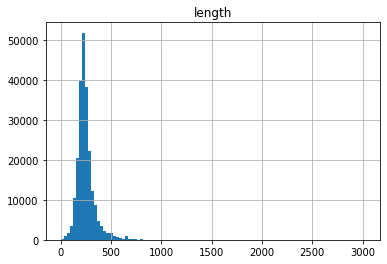

In [108]:
# histogram for length
df_valid.select("length").toPandas().hist(bins=100);

In [109]:
# level
df.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [110]:
# location
df.select("location").dropDuplicates().show(10, False)

+--------------------------------------+
|location                              |
+--------------------------------------+
|Gainesville, FL                       |
|Atlantic City-Hammonton, NJ           |
|Deltona-Daytona Beach-Ormond Beach, FL|
|San Diego-Carlsbad, CA                |
|Cleveland-Elyria, OH                  |
|Kingsport-Bristol-Bristol, TN-VA      |
|New Haven-Milford, CT                 |
|Birmingham-Hoover, AL                 |
|Corpus Christi, TX                    |
|Dubuque, IA                           |
+--------------------------------------+
only showing top 10 rows



In [111]:
# method
df.select("method").dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [112]:
# page
df.select("page").dropDuplicates().show(22, False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



In [113]:
# registration
df.select("registration").show(5)

+-------------+
| registration|
+-------------+
|1538173362000|
|1538331630000|
|1538173362000|
|1538331630000|
|1538173362000|
+-------------+
only showing top 5 rows



In [114]:
# songs
df.select("song").show(5, False)

+-----------------------------+
|song                         |
+-----------------------------+
|Rockpools                    |
|Canada                       |
|Time For Miracles            |
|Knocking On Forbidden Doors  |
|Harder Better Faster Stronger|
+-----------------------------+
only showing top 5 rows



In [115]:
# number of songs
df.select("song").drop_duplicates().count()

58481

In [116]:
# status
df.select("status").drop_duplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [117]:
# ts
df.select("ts").show(5)

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
+-------------+
only showing top 5 rows



In [118]:
# userAgent
df_valid.select("userAgent").drop_duplicates().show(10, False)

+--------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                  |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"|


## Define Churn

Define churn events as`Cancellation Confirmation` events.
Create a column `churn_user` to use as the label for the model. 

In [119]:
# define churn event
flag_churn_event = F.udf(
    lambda x: 1 if x == 'Cancellation Confirmation' else 0, T.IntegerType())

# create churn event column
df_valid = df_valid.withColumn('churn_event', flag_churn_event('page'))

# create churn user column
df_valid = df_valid.withColumn('churn_user', F.max(
    'churn_event').over(Window.partitionBy('userId')))

In [120]:
df_valid.groupBy('churn_user').count().show()

+----------+------+
|churn_user| count|
+----------+------+
|         1| 44864|
|         0|233290|
+----------+------+



In [121]:
44864/(44864 + 233290) * 100

16.129194618808288

## Explore Data
More exploratory data analysis to observe the behavior for users who stayed vs users who churned. The relations between users' attributes such as gender, level, location, and churn events are explored. 
We also explore aggregates on these two groups of users, observing how much of a specific action they experienced such as number of songs played or how many times they visited home page per day.

In [122]:
# number of churn and not churn users
num_churn_users = df_valid.filter(df_valid['churn_user'] == '1').select(
    F.countDistinct('userId')).collect()[0][0]
num_not_churn_users = num_users - num_churn_users
print("number of churn users:", num_churn_users)
print("number of not churn users:", num_not_churn_users)

number of churn users: 52
number of not churn users: 173


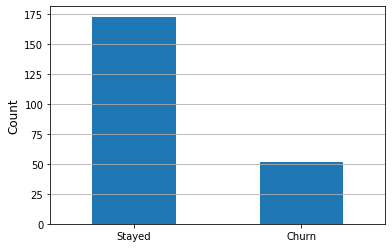

In [123]:
d = {'churns': [num_not_churn_users, num_churn_users]}
df_churns = pd.DataFrame(data=d, index=['Stayed', 'Churn'])
ax = df_churns.plot.bar(legend=False)
ax.grid(axis='y')
ax.set_ylabel('Count', fontsize=12)
plt.xticks(rotation=0);

In [124]:
# create datetime columns for registration and timestamp
df_valid = df_valid.withColumn(
    'registration_dt', (F.col('registration')/1000).cast(T.TimestampType()))
df_valid = df_valid.withColumn(
    'dt', (F.col('ts')/1000).cast(T.TimestampType()))

In [125]:
# churn users
churn_users_pd = df_valid.filter(df_valid['churn_user']==1).select(
    'userId','firstName', 'lastName').dropDuplicates().sort('lastName').toPandas()
churn_users_pd.head()

,userId,firstName,lastName
0,73,Rachel,Bailey
1,100011,Sebastian,Ball
2,100006,Leyla,Barnes
3,58,Erick,Brooks
4,100013,Cali,Brown


In [126]:
# example of churn by `Cancellation Confirmation`
df_valid.select('userId', 'firstName', 'page', 'dt', 'level').where((df_valid['userId'] == 73) & (
    (df_valid['page'] == 'Submit Downgrade') | (df_valid['page'] == 'Cancellation Confirmation'))).show(5, False)

+------+---------+-------------------------+-------------------+-----+
|userId|firstName|page                     |dt                 |level|
+------+---------+-------------------------+-------------------+-----+
|73    |Rachel   |Cancellation Confirmation|2018-10-24 12:33:07|paid |
+------+---------+-------------------------+-------------------+-----+



In [127]:
# example of Submit Downgrade`
df_valid.select('userId', 'firstName', 'page', 'dt', 'level').where((df_valid['userId'] == 39) & (
    (df_valid['page'] == 'Submit Downgrade') | (df_valid['page'] == 'Cancellation Confirmation'))).show(5, False)

+------+---------+----------------+-------------------+-----+
|userId|firstName|page            |dt                 |level|
+------+---------+----------------+-------------------+-----+
|39    |Payton   |Submit Downgrade|2018-11-03 09:29:32|paid |
|39    |Payton   |Submit Downgrade|2018-11-04 12:58:57|paid |
|39    |Payton   |Submit Downgrade|2018-11-16 19:49:48|paid |
+------+---------+----------------+-------------------+-----+



In [128]:
# example of churn by `Submit Downgrade` followed by `Cancellation Confirmation`
df_valid.select('userId', 'firstName', 'page', 'dt', 'level').where((df_valid['userId'] == 103) & (
    (df_valid['page'] == 'Submit Downgrade') | (df_valid['page'] == 'Cancellation Confirmation'))).show(5, False)

+------+---------+-------------------------+-------------------+-----+
|userId|firstName|page                     |dt                 |level|
+------+---------+-------------------------+-------------------+-----+
|103   |Piper    |Submit Downgrade         |2018-10-15 18:56:25|paid |
|103   |Piper    |Cancellation Confirmation|2018-11-04 08:01:31|paid |
+------+---------+-------------------------+-------------------+-----+



### Gender

In [129]:
num_females = df_valid.filter(df_valid['gender'] == 'F').select(
    F.countDistinct('userId')).collect()[0][0]
num_males = num_users - num_females
print("number of females:", num_females)
print("number of males:", num_males)

number of females: 104
number of males: 121


In [130]:
df_gender = df_valid.groupby('gender').sum('churn_event').toPandas()
df_gender['count'] = [num_females, num_males]
df_gender['percent churn'] = df_gender['sum(churn_event)'] / \
    df_gender['count']*100
df_gender.columns = ['gender', 'num_churns', 'count', 'percent churn']
df_gender.set_index('gender')

,num_churns,count,percent churn
gender,,,
F,20,104,19.230769
M,32,121,26.446281


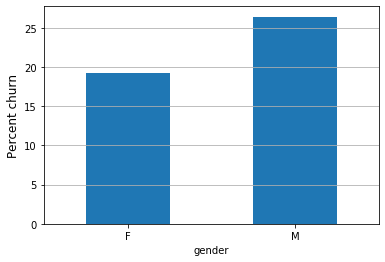

In [131]:
ax = df_gender.plot.bar(x='gender', y='percent churn', legend=False)
ax.grid(axis='y')
ax.set_ylabel('Percent churn', fontsize=12)
plt.xticks(rotation=0);

### Level

In [132]:
num_free = df_valid.filter(df_valid['level'] == 'free').select(
    F.countDistinct('userId')).collect()[0][0]
num_paid = df_valid.filter(df_valid['level'] == 'paid').select(
    F.countDistinct('userId')).collect()[0][0]

In [133]:
df_level = df_valid.groupby('level').sum('churn_event').toPandas()
df_level['count'] = [num_free, num_paid]
df_level['percent churn'] = df_level['sum(churn_event)'] / \
    df_level['count'] * 100
df_level.columns = ['level', 'num_churns', 'count', 'percent churn']
df_level.set_index('level')

,num_churns,count,percent churn
level,,,
free,21,195,10.769231
paid,31,165,18.787879


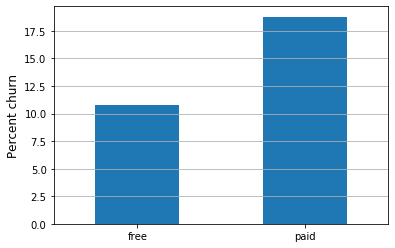

In [134]:
ax = df_level.plot.bar(x='level', y='percent churn', legend=False)
ax.grid(axis='y')
ax.set_ylabel('Percent churn', fontsize=12)
ax.set_xlabel('')
plt.xticks(rotation=0);

### Location

In [135]:
df_valid.select("location").show(10, False)

+------------------------------+
|location                      |
+------------------------------+
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Boston-Cambridge-Newton, MA-NH|
|Boston-Cambridge-Newton, MA-NH|
|Bakersfield, CA               |
|Bakersfield, CA               |
|Bakersfield, CA               |
+------------------------------+
only showing top 10 rows



In [136]:
# get state from location
get_state = F.udf(lambda x: x[-2:])

# create state column
df_valid = df_valid.withColumn("state", get_state(df_valid['location']))

In [137]:
df_state_counts = df_valid.select(
    'userId', 'state').dropDuplicates().groupby('state').count().toPandas()

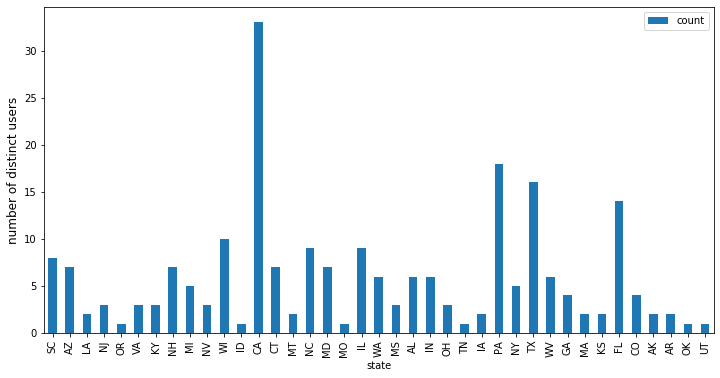

In [138]:
ax = df_state_counts.plot.bar(x='state', y='count',
                              figsize=(12, 6))
ax.set_ylabel('number of distinct users', fontsize=12);

In [139]:
df_state_churns = df_valid.groupby('state').sum('churn_event').toPandas()
df_state_churns.columns = ['state', 'num_churns']

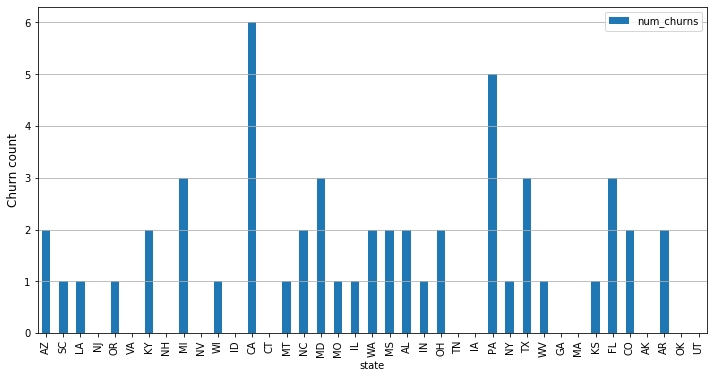

In [140]:
ax = df_state_churns.plot.bar(x='state', y='num_churns', figsize=(12, 6))
ax.grid(axis='y')
ax.set_ylabel('Churn count', fontsize=12);

In [141]:
df_state_churns['percent churn'] = df_state_churns['num_churns'] / \
    df_state_counts['count'] * 100

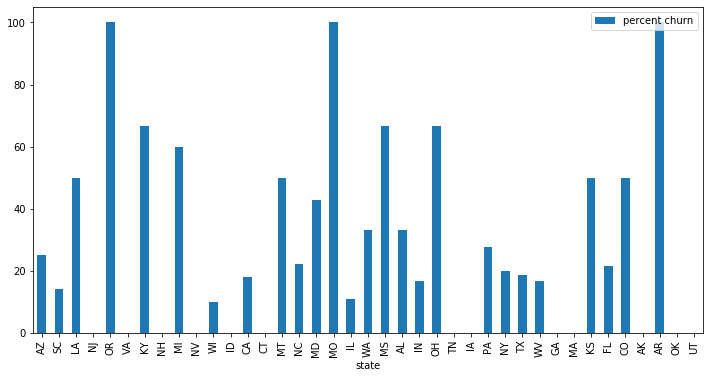

In [142]:
df_state_churns.plot.bar(x='state', y='percent churn', figsize=(12, 6));

### Registration

In [143]:
# find earliest and latest registration dates
start_reg_date = df_valid.agg({'registration_dt': 'min'}).collect()
end_reg_date = df_valid.agg({'registration_dt': 'max'}).collect()
print('registration start date:', str(start_reg_date[0][0]))
print('registration end date:', str(end_reg_date[0][0]))

registration start date: 2018-03-18 08:44:35
registration end date: 2018-11-26 09:49:14


In [144]:
# find earliest and latest dates (from timestamp)
start_date = df_valid.agg({'dt': 'min'}).collect()
end_date = df_valid.agg({'dt': 'max'}).collect()
print('start date:', str(start_date[0][0]))
print('end date:', str(end_date[0][0]))

start date: 2018-09-30 19:01:57
end date: 2018-12-02 19:11:16


In [145]:
# number of days since registration
df_valid = df_valid.withColumn("days_since_reg", F.max(
    F.datediff('dt', 'registration_dt')).over(Window.partitionBy('userId')))

In [146]:
df_valid.select('days_since_reg').describe().show()

+-------+-----------------+
|summary|   days_since_reg|
+-------+-----------------+
|  count|           278154|
|   mean|88.91284684023958|
| stddev| 40.4933547852528|
|    min|                0|
|    max|              256|
+-------+-----------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80cf95ba90>]],
      dtype=object)

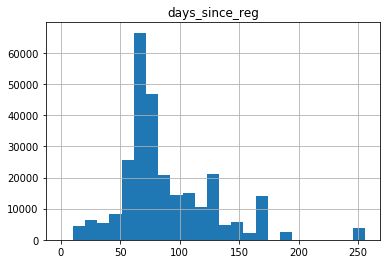

In [147]:
df_valid.select('days_since_reg').toPandas().hist(bins=25)

In [148]:
df_days_stayed = df_valid.filter(
    df_valid['churn_user'] == 0).select('days_since_reg').toPandas()
df_days_churn = df_valid.filter(
    df_valid['churn_user'] == 1).select('days_since_reg').toPandas()
df_reg_days = pd.concat([df_days_stayed, df_days_churn], axis=1, ignore_index=True)
df_reg_days.columns = ['stayed', 'churn']

In [149]:
df_reg_days.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
stayed,233290.0,92.999773,38.790168,0.0,67.0,77.0,115.0,256.0
churn,44864.0,67.661087,42.466799,5.0,42.0,56.0,80.0,188.0


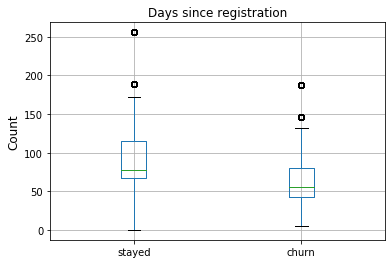

In [150]:
ax = df_reg_days.boxplot()
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Days since registration');

### Timestamp

In [151]:
get_hour = F.udf(lambda x: datetime.datetime.fromtimestamp(
    x / 1000.0).hour, T.IntegerType())
get_day = F.udf(lambda x: datetime.datetime.fromtimestamp(
    x / 1000.0).day, T.IntegerType())
get_month = F.udf(lambda x: datetime.datetime.fromtimestamp(
    x / 1000.0).month, T.IntegerType())

In [152]:
df_valid = df_valid.withColumn('hour', get_hour(F.col('ts')))\
    .withColumn('day', get_day(F.col('ts')))\
    .withColumn('month', get_month(F.col('ts')))

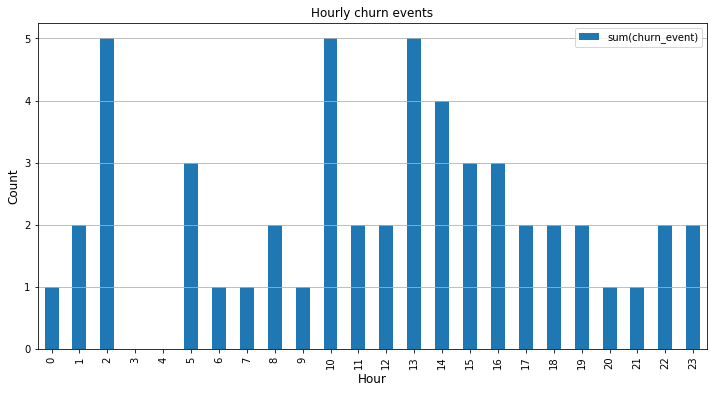

In [153]:
ax = df_valid.groupBy('hour').sum('churn_event').sort('hour').toPandas(
).plot.bar(x='hour', y='sum(churn_event)', figsize=(12, 6))
ax.grid(axis='y')
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Hourly churn events');

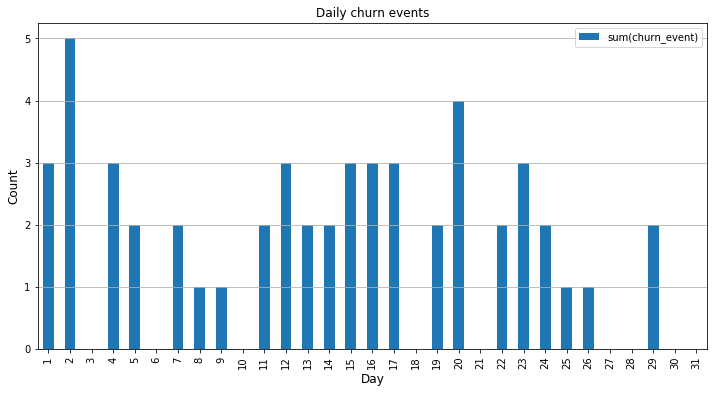

In [154]:
ax = df_valid.groupBy('day').sum('churn_event').sort('day').toPandas(
).plot.bar(x='day', y='sum(churn_event)', figsize=(12, 6))
ax.grid(axis='y')
ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Daily churn events');

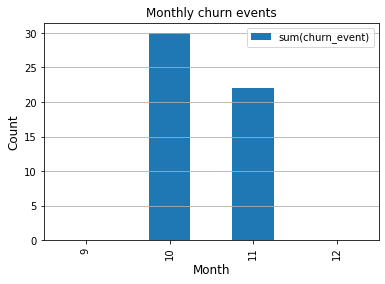

In [155]:
ax = df_valid.groupBy('month').sum('churn_event').sort(
    'month').toPandas().plot.bar(x='month', y='sum(churn_event)')
ax.grid(axis='y')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Monthly churn events');

### Song

In [156]:
# time window to find number of songs played in a day
def days(x): 
    " Return time in seconds for the input time in days"
    time_in_seconds = x * 86400
    return time_in_seconds


windowval = (
    Window.partitionBy("userId")
    .orderBy(F.col("ts")/1000)
    .rangeBetween(-days(1), 0)
)

In [157]:
# number of songs played in a day
df_valid = df_valid.withColumn("num_songs", F.count("song").over(windowval))

In [158]:
# check
df_valid.select('userId', 'dt', 'song', 'num_songs', 'churn_event',
                'churn_user').where(df_valid['userId'] == 32).show(200)

+------+-------------------+--------------------+---------+-----------+----------+
|userId|                 dt|                song|num_songs|churn_event|churn_user|
+------+-------------------+--------------------+---------+-----------+----------+
|    32|2018-10-03 10:01:37|Beyond The Beyond...|        1|          0|         1|
|    32|2018-10-03 10:05:34|       Paradise City|        2|          0|         1|
|    32|2018-10-03 10:12:20|           Alejandro|        3|          0|         1|
|    32|2018-10-03 10:12:45|                null|        3|          0|         1|
|    32|2018-10-03 10:16:54|        Luv U Better|        4|          0|         1|
|    32|2018-10-03 10:16:55|                null|        4|          0|         1|
|    32|2018-10-03 10:20:56|My Life Would Suc...|        5|          0|         1|
|    32|2018-10-03 10:21:08|                null|        5|          0|         1|
|    32|2018-10-03 10:24:27|Jamaica Roots II(...|        6|          0|         1|
|   

In [159]:
def make_boxplot(df, col_name):
    "Return boxplot of stayed and churn for the attribute col_name of the dataframe df."
    df_stayed = df.filter(df['churn_user'] == 0).select(
        col_name).toPandas()
    df_churn = df.filter(df['churn_user'] == 1).select(
        col_name).toPandas()

    df = pd.concat([df_stayed, df_churn], axis=1, ignore_index=True)
    df.columns = ['stayed', 'churn']

    statistics = df.describe().transpose()

    ax = df.boxplot()
    ax.set_title(col_name + ' per day', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)

    return statistics, ax

(           count        mean        std  min   25%   50%    75%    max
 stayed  233290.0  111.262995  94.196390  0.0  34.0  85.0  165.0  364.0
 churn    44864.0  106.231232  92.774793  0.0  31.0  78.0  157.0  372.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80ccdd6f10>)

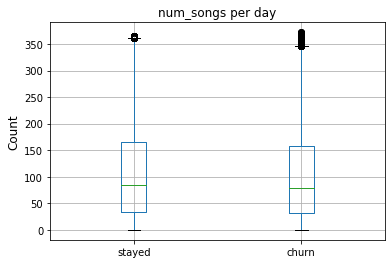

In [160]:
make_boxplot(df_valid, 'num_songs')

### Artist

In [161]:
# number of distinct artists played in a day
df_valid = df_valid.withColumn("num_artists", F.size(
    F.collect_set("artist").over(windowval)))

(           count        mean        std  min   25%   50%    75%    max
 stayed  233290.0  103.620425  84.233414  0.0  34.0  82.0  155.0  331.0
 churn    44864.0   99.120185  83.465901  0.0  31.0  75.0  148.0  332.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80cbba53d0>)

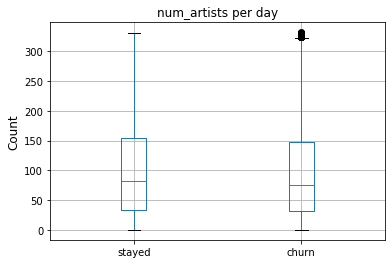

In [162]:
make_boxplot(df_valid, 'num_artists')

### Session

In [163]:
# number of sessions in a day
df_valid = df_valid.withColumn('num_sessions', F.count('sessionId').over(windowval))

(           count        mean         std  min   25%    50%    75%    max
 stayed  233290.0  133.449441  111.058138  1.0  42.0  103.0  198.0  439.0
 churn    44864.0  128.028731  108.969669  1.0  39.0   96.0  190.0  436.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80cc839410>)

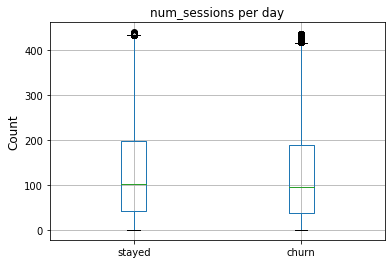

In [164]:
make_boxplot(df_valid, 'num_sessions')

### Status

In [165]:
df_valid.groupby('status').count().show()

+------+------+
|status| count|
+------+------+
|   307| 23184|
|   404|   252|
|   200|254718|
+------+------+



In [166]:
# flag the status 'redirect' and 'not found'
flag_redirect = F.udf(lambda x: 1 if x == 307 else 0, T.IntegerType())
flag_not_found = F.udf(lambda x: 1 if x == 404 else 0, T.IntegerType())

In [167]:
# create redirect and page_not_found columns
df_valid = df_valid.withColumn("redirect", flag_redirect(df_valid['status']))
df_valid = df_valid.withColumn(
    "page_not_found", flag_not_found(df_valid['status']))

In [168]:
df_valid.groupBy('churn_user').sum('redirect').show()

+----------+-------------+
|churn_user|sum(redirect)|
+----------+-------------+
|         1|         3695|
|         0|        19489|
+----------+-------------+



In [169]:
df_valid.groupBy('churn_user').sum('page_not_found').show()

+----------+-------------------+
|churn_user|sum(page_not_found)|
+----------+-------------------+
|         1|                 32|
|         0|                220|
+----------+-------------------+



In [170]:
df_valid.filter(df_valid['status'] == '307').select(
    F.sum("churn_event")).show()

+----------------+
|sum(churn_event)|
+----------------+
|               0|
+----------------+



In [171]:
df_valid.filter(df_valid['status'] == '200').select(
    F.sum("churn_event")).show()

+----------------+
|sum(churn_event)|
+----------------+
|              52|
+----------------+



### Page

In [172]:
df_valid.groupby('page').count().show(22, False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Cancel                   |52    |
|Submit Downgrade         |63    |
|Thumbs Down              |2546  |
|Home                     |10082 |
|Downgrade                |2055  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Save Settings            |310   |
|Cancellation Confirmation|52    |
|About                    |495   |
|Settings                 |1514  |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Help                     |1454  |
|Upgrade                  |499   |
|Error                    |252   |
|Submit Upgrade           |159   |
+-------------------------+------+



In [173]:
# create aggregate features from the column 'page'

pages = ['Thumbs Down', 'Thumbs Up', 'Home', 'Roll Advert',
         'Logout', 'Add to Playlist', 'Add Friend', 'Error']

for page in pages:
    flag_page = F.udf(lambda x: 1 if x == page else 0, T.IntegerType())
    df_valid = df_valid.withColumn('flag', flag_page('page'))
    df_valid = df_valid.withColumn(
        'num_' + page, F.sum('flag').over(windowval)).drop('flag')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  1.110493  1.446443  0.0  0.0  1.0  2.0  13.0
 churn    44864.0  1.183488  1.407353  0.0  0.0  1.0  2.0   7.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80cc35cd50>)

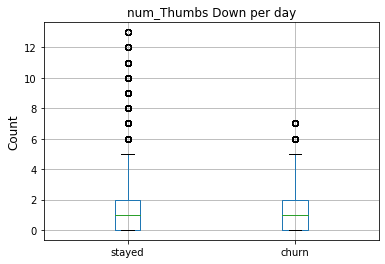

In [174]:
make_boxplot(df_valid, 'num_Thumbs Down')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  6.013112  5.820115  0.0  1.0  4.0  9.0  38.0
 churn    44864.0  5.338802  5.187177  0.0  1.0  4.0  8.0  30.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80ce1672d0>)

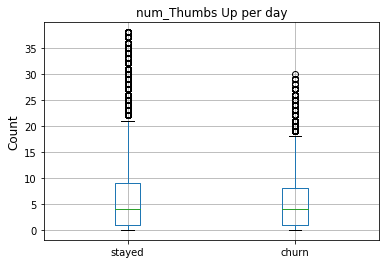

In [175]:
make_boxplot(df_valid, 'num_Thumbs Up')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  4.506485  3.661779  0.0  2.0  4.0  7.0  22.0
 churn    44864.0  4.512750  3.883828  0.0  2.0  4.0  6.0  20.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80cd430790>)

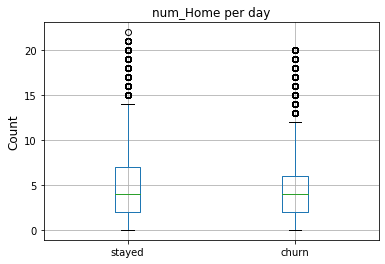

In [176]:
make_boxplot(df_valid, 'num_Home')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  0.956385  2.436229  0.0  0.0  0.0  1.0  38.0
 churn    44864.0  1.591789  3.476550  0.0  0.0  0.0  1.0  27.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80cd9d1ed0>)

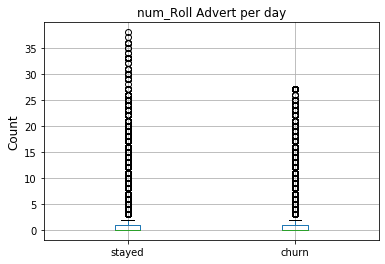

In [177]:
make_boxplot(df_valid, 'num_Roll Advert')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  1.309340  1.527900  0.0  0.0  1.0  2.0  10.0
 churn    44864.0  1.351863  1.555943  0.0  0.0  1.0  2.0   9.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80cd4c37d0>)

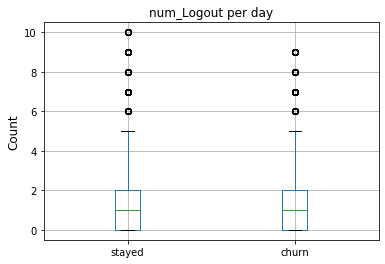

In [178]:
make_boxplot(df_valid, 'num_Logout')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  3.135557  3.176421  0.0  1.0  2.0  5.0  19.0
 churn    44864.0  3.046451  3.223029  0.0  1.0  2.0  4.0  17.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80b19e1e90>)

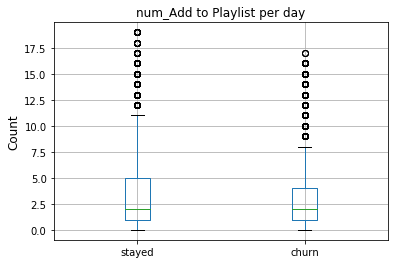

In [179]:
make_boxplot(df_valid, 'num_Add to Playlist')

(           count      mean       std  min  25%  50%  75%   max
 stayed  233290.0  2.028672  2.535615  0.0  0.0  1.0  3.0  21.0
 churn    44864.0  1.692961  2.089752  0.0  0.0  1.0  3.0  11.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80b1a17b10>)

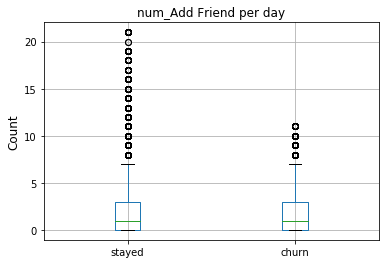

In [180]:
make_boxplot(df_valid, 'num_Add Friend')

(           count      mean       std  min  25%  50%  75%  max
 stayed  233290.0  0.122534  0.371318  0.0  0.0  0.0  0.0  3.0
 churn    44864.0  0.091922  0.303371  0.0  0.0  0.0  0.0  2.0,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80b1a1ff90>)

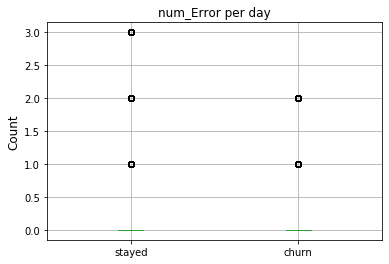

In [181]:
make_boxplot(df_valid, 'num_Error')

In [182]:
df_temp = df_valid.select(
    'churn_user',
    'itemInSession',
    'length',
    'days_since_reg',
    'hour',
    'day',
    'month',
    'num_songs',
    'num_artists',
    'num_sessions',
    'num_Thumbs Down',
    'num_Thumbs Up',
    'num_Home',
    'num_Roll Advert',
    'num_Logout',
    'num_Add to Playlist',
    'num_Add Friend',
    'num_Error'
).toPandas()

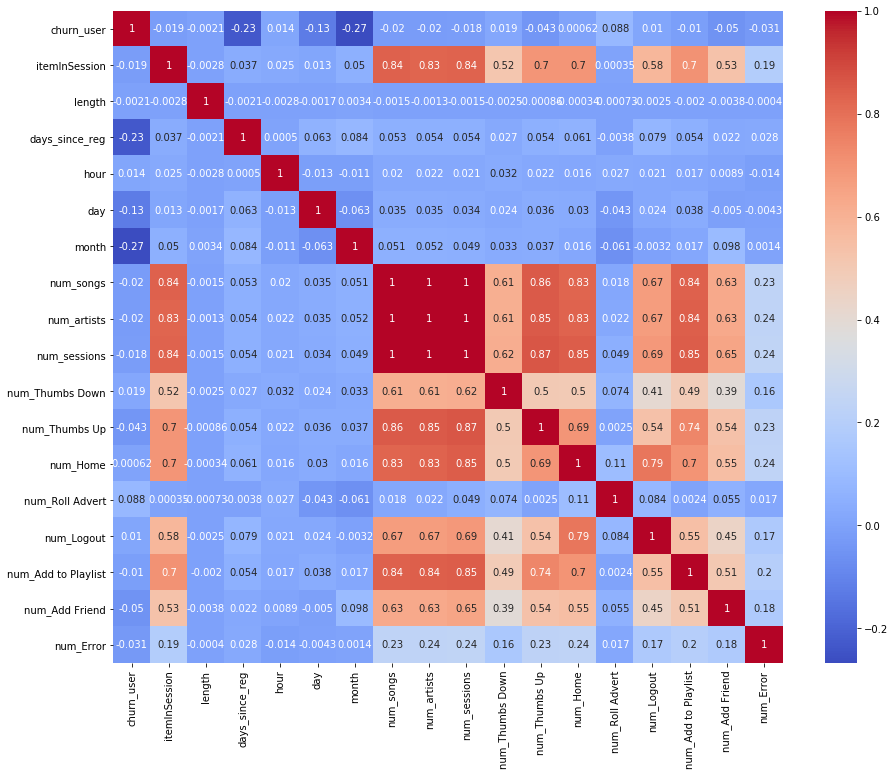

In [183]:
plt.figure(figsize=(15, 12))
sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm');
#plt.ylim(12, 0)

Highly correlated features will be dropped to avoid multicollinearity. 

In [184]:
df_temp = df_valid.select(
    'churn_user',
    'length',
    'days_since_reg',
    'hour',
    'day',
    'month',
    'num_songs',
    'num_Thumbs Down',
    'num_Roll Advert',
    'num_Add Friend',
    'num_Error'
).toPandas()

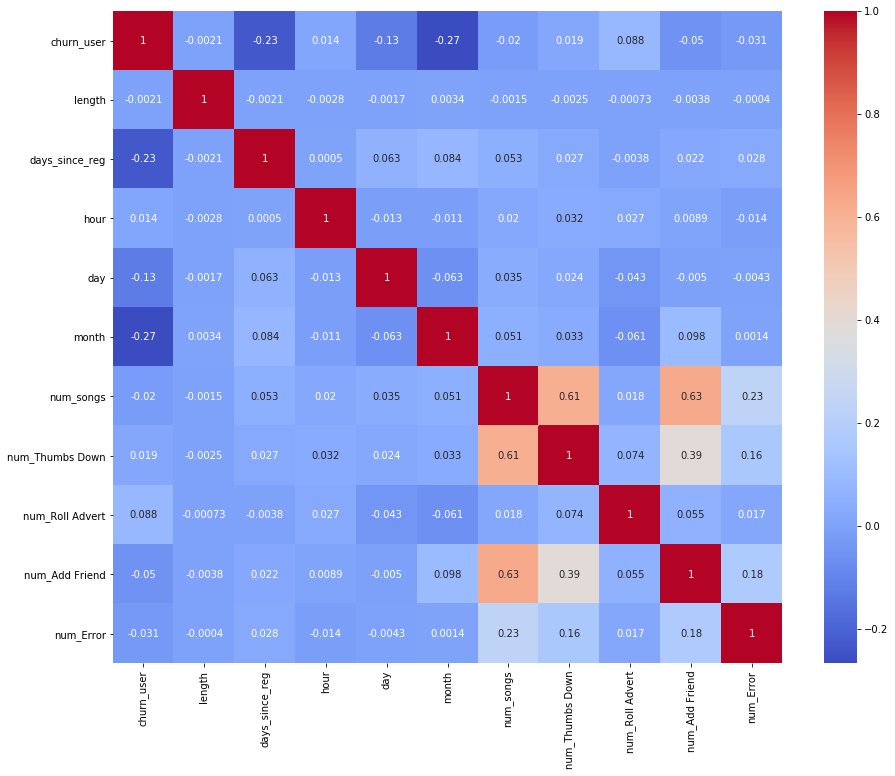

In [185]:
plt.figure(figsize=(15, 12))
sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm');
#plt.ylim(12, 0)

# Feature Engineering

In [6]:
def clean_data(df):
    "Return valid data by dropping missing values in registration."
    df_clean = df.dropna(subset=['registration']).na.fill(0, subset=['length'])

    return df_clean

In [7]:
def is_churn(df):
    "Return the dataframe with labels for churn users"
    
    flag_churn_event = F.udf(lambda x: 1 if (x == 'Cancellation Confirmation') | (
        x == 'Submit Downgrade') else 0, T.IntegerType())

    df_new = df.withColumn(
        'churn_event', flag_churn_event(F.col('page')))
    
    df_new = df_new.withColumn('label', F.max(
        'churn_event').over(Window.partitionBy('userId')))

    return df_new

In [8]:
def registration_days(df):
    "Return the number of days since registration"

    df_new = df.withColumn('registration date', (F.col(
    'registration')/1000).cast(T.TimestampType()))

    df_new = df_new.withColumn(
    'date', (F.col('ts')/1000).cast(T.TimestampType()))

    df_new = df_new.withColumn('days_since_registration', (F.datediff(
    'date', 'registration date'))).drop('date', 'registration date')

    return df_new

In [9]:
def timestamp(df):

    get_hour = F.udf(lambda x: datetime.datetime.fromtimestamp(
        x / 1000.0).hour, T.IntegerType())
    get_day = F.udf(lambda x: datetime.datetime.fromtimestamp(
        x / 1000.0).day, T.IntegerType())
    get_month = F.udf(lambda x: datetime.datetime.fromtimestamp(
        x / 1000.0).month, T.IntegerType())

    df_new = df.withColumn('hour', get_hour(F.col('ts'))).withColumn(
        'day', get_day(F.col('ts'))).withColumn('month', get_month(F.col('ts')))
    
    return df_new

In [10]:
# time window to find aggregate values per day
def days(x): 
    " Return time in seconds for the input time in days"
    time_in_seconds = x * 86400
    return time_in_seconds

windowval = (
    Window.partitionBy("userId")
    .orderBy(F.col("ts")/1000)
    .rangeBetween(-days(1), 0)
)

In [11]:
# create aggregate features from the column 'page'
pages = ['Thumbs Down', 'Roll Advert', 'Add Friend', 'Error']

def aggregate_features(df):
    "Return selected aggregate features from page."
    df_new = df
    
    for page in pages:
        
        flag_page = F.udf(lambda x: 1 if x == page else 0, T.IntegerType())
        df_new = df_new.withColumn('flag', flag_page('page'))
        df_new = df_new.withColumn(
            'num_' + page, F.sum('flag').over(windowval)).drop('flag')
    
    # number of songs played in a day
    df_new = df_new.withColumn('num_songs', F.count('song').over(windowval))
    
    return df_new

In [12]:
def retrive_state(df):
    "Return dataframe with states retrived from locations"
    df_new = df
    get_state = F.udf(lambda x: x[-2:])
    df_new = df_new.withColumn("state", get_state(
        df_new['location'])).drop('location')
    
    return df_new    

In [13]:
ignore_list = ['artist',
               'auth',
               'firstName',
               'itemInSession',
               'lastName',
               'method',
               'page',
               'registration',
               'sessionId',
               'song',
               'ts',
               'userAgent',
               'userId',
               'churn_event',
               ]


def ignore(df, ignore_list):
    "Remove unnecessary feature columns"
    df_new = df.drop(*ignore_list)

    return df_new

In [14]:
def preprocess_data(df):
    
    df_clean = clean_data(df)
    df_churn = is_churn(df_clean)
    df_reg_days = registration_days(df_churn)
    df_timestamp = timestamp(df_reg_days)
    df_aggregate = aggregate_features(df_timestamp)
    df_state = retrive_state(df_aggregate)
    df_processed = ignore(df_state, ignore_list)
    
    return df_processed    

In [15]:
df_processed = preprocess_data(df)

In [16]:
df_processed.columns

['gender',
 'length',
 'level',
 'status',
 'label',
 'days_since_registration',
 'hour',
 'day',
 'month',
 'num_Thumbs Down',
 'num_Roll Advert',
 'num_Add Friend',
 'num_Error',
 'num_songs',
 'state']

In [17]:
cat_columns = ['gender', 'level', 'status', 'state', 'month']

stages = []

for column in cat_columns:
    indexer = StringIndexer(inputCol=column, outputCol=column+'_index')
    encoder = OneHotEncoderEstimator(
        inputCols=[indexer.getOutputCol()], outputCols=[column + '_vect'])

    stages += [indexer, encoder]

In [18]:
num_columns = [
    'length',
    'days_since_registration',
    'hour',
    'day',
    'num_songs',
    'num_Thumbs Down',
    'num_Roll Advert',
    'num_Add Friend',
    'num_Error'
]

vect_assembler_inputs = [c + '_vect' for c in cat_columns] + num_columns
assembler = VectorAssembler(
    inputCols=vect_assembler_inputs, outputCol="features")

stages += [assembler]

In [19]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

stages += [scaler]

# Modeling
Split the full dataset into train and test sets. 
Test out several classifiers with default parameters, and evaluate F1 scores, and areaUnderROC scores since the churned users are a fairly small subset.
The best model's parameters are further tuned to optimize F1 score with 2-fold crossvalidation. 

In [20]:
# split the full dataset into train, test, and validation sets
train, test = df_processed.randomSplit([0.8, 0.2], seed=42)
# display shape of datasets
print('df_processed shape: {}, {}'.format(df_processed.count(), len(df_processed.columns)))
print('train shape: {}, {}'.format(train.count(), len(train.columns)))
print('test shape: {}, {}'.format(test.count(),len(test.columns)))

In [21]:
pipeline = Pipeline().setStages(stages)
pipeline_fitted = pipeline.fit(train)

In [22]:
train_prep = pipeline_fitted.transform(train)
test_prep = pipeline_fitted.transform(test)

In [23]:
lr = LogisticRegression(labelCol='label', featuresCol='scaled_features')
dtc = DecisionTreeClassifier(labelCol='label', featuresCol='scaled_features')
rfc = RandomForestClassifier(labelCol='label', featuresCol='scaled_features')
gbt = GBTClassifier(labelCol='label', featuresCol='scaled_features')

In [24]:
lr_model = lr.fit(train_prep)
dtc_model = dtc.fit(train_prep)
rfc_model = rfc.fit(train_prep)
gbt_model = gbt.fit(train_prep)

In [25]:
lr_preds = lr_model.transform(test_prep)
dtc_preds = dtc_model.transform(test_prep)
rfc_preds = rfc_model.transform(test_prep)
gbt_preds = gbt_model.transform(test_prep)

In [26]:
f1_eval = MulticlassClassificationEvaluator(
    labelCol='label', metricName='f1')

In [27]:
lr_f1 = f1_eval.evaluate(lr_preds)
dtc_f1 = f1_eval.evaluate(dtc_preds)
rfc_f1 = f1_eval.evaluate(rfc_preds)
gbt_f1 = f1_eval.evaluate(gbt_preds)

In [28]:
print('f1 scores')
print('LR:', lr_f1)
print('DTC:', dtc_f1)
print('RFC:', rfc_f1)
print('GBT:', gbt_f1)

f1 scores
LR: 0.7290026220774705
DTC: 0.6803727575530918
RFC: 0.6953315535684006
GBT: 0.8220295991158422


In [29]:
AUC_eval = BinaryClassificationEvaluator(
    labelCol='label', metricName="areaUnderROC")

In [30]:
lr_AUC = AUC_eval.evaluate(lr_preds)
dtc_AUC = AUC_eval.evaluate(dtc_preds)
rfc_AUC = AUC_eval.evaluate(rfc_preds)
gbt_AUC = AUC_eval.evaluate(gbt_preds)

In [31]:
print('AUC')
print('LR:', lr_AUC)
print('DTC:', dtc_AUC)
print('RFC:', rfc_AUC)
print('GBT:', gbt_AUC)

AUC
LR: 0.8210744161766961
DTC: 0.5983195171972127
RFC: 0.7895412688451344
GBT: 0.9074594517743301


In [83]:
# create a dataframe for metrics
d = {'Classifier': ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier','GBTClassifier'],
     'F1': [lr_f1, dtc_f1, rfc_f1, gbt_f1], 
     'AUC': [lr_AUC, dtc_AUC, rfc_AUC, gbt_AUC]}

df_metrics = pd.DataFrame(data=d)

In [84]:
df_metrics

,Classifier,F1,AUC
0,LogisticRegression,0.729003,0.821074
1,DecisionTreeClassifier,0.680373,0.598320
2,RandomForestClassifier,0.695332,0.789541
3,GBTClassifier,0.822030,0.907459


### Model Selection

In [32]:
# Create param_grid for Cross Validation
param_grid = (ParamGridBuilder()
             .addGrid(gbt.stepSize, [0.1, 0.5]) 
             .addGrid(gbt.maxDepth, [5, 10])
             .addGrid(gbt.maxBins, [16, 32])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

In [33]:
cv = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=param_grid,
    evaluator=f1_eval,
    numFolds=2)

cv_model = cv.fit(train_prep)

In [90]:
cv_preds = cv_model.transform(test_prep)

In [188]:
cv_f1 = f1_eval.evaluate(cv_preds)
print('best_model F1 score:', cv_f1)

best_model F1 score: 0.9884232174649019


In [89]:
# extract best model's parameters
cv_model.bestModel.extractParamMap()

{Param(parent='GBTClassifier_70d64f254b2b', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_70d64f254b2b', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_70d64f254b2b', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_70d64f254b2b', name='featuresCol', doc='features column name'): 'scaled_features',
 Param(parent='GBTClassifier_70d64f254b2b', name='labelCol', doc='label column name

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.